**Installing and Importing libraries**

In [1]:
!pip install pgmpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

Libraries


In [2]:
#data managing libraraies
import pandas as pd
import numpy as np
#for bayesian network
from pgmpy.models import BayesianNetwork
from pgmpy.inference import VariableElimination
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator
from pgmpy.estimators import HillClimbSearch
import itertools
#for splitting data
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
#for data plotting and exploring
import matplotlib.pyplot as plt
import networkx as nx




**Data Preprocessing**

Checking about null values and Selecting features that are more relevant

In [3]:
data=pd.read_csv('adult.csv')
#selecting imp features of data
selected_features=["age","workclass","education",
"marital.status","occupation",
"relationship",
"race",
"sex","hours.per.week",
"native.country","income"
]

data=data[selected_features]
data.dropna(inplace=True)
print(data.head())
data.shape


   age workclass     education marital.status         occupation  \
0   90         ?       HS-grad        Widowed                  ?   
1   82   Private       HS-grad        Widowed    Exec-managerial   
2   66         ?  Some-college        Widowed                  ?   
3   54   Private       7th-8th       Divorced  Machine-op-inspct   
4   41   Private  Some-college      Separated     Prof-specialty   

    relationship   race     sex  hours.per.week native.country income  
0  Not-in-family  White  Female              40  United-States  <=50K  
1  Not-in-family  White  Female              18  United-States  <=50K  
2      Unmarried  Black  Female              40  United-States  <=50K  
3      Unmarried  White  Female              40  United-States  <=50K  
4      Own-child  White  Female              40  United-States  <=50K  


(32561, 11)

Also some of the entries was contained null value but in '?' so also remove those

In [4]:
#print(data.head())
data = data[~data.isin(['?']).any(axis=1)]
count_question = data.isin(['?']).sum()
print(data.shape)

(30162, 11)


In [5]:
#data=pd.read_csv('adult.csv')
print(data.isnull().sum())
print(data.shape)

age               0
workclass         0
education         0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
hours.per.week    0
native.country    0
income            0
dtype: int64
(30162, 11)


**Plotting to divide into bins**

Max: 90
Min: 17


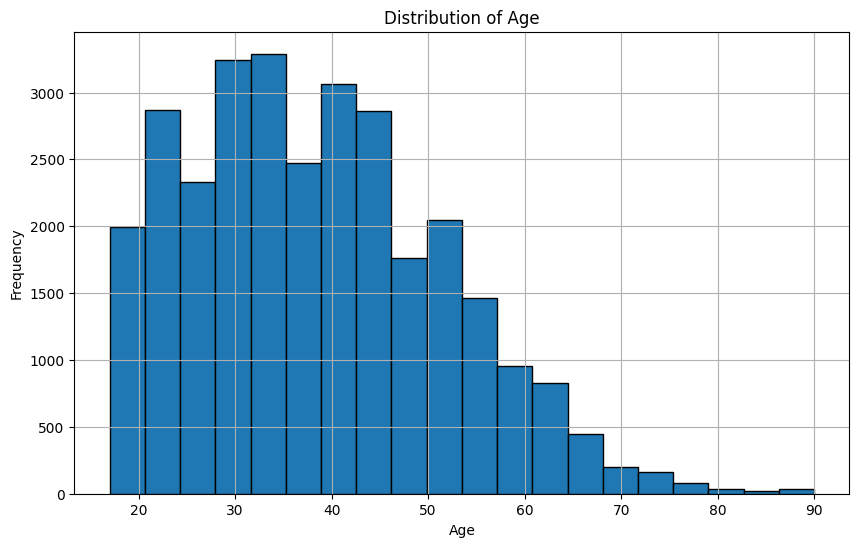

In [6]:
temp=data["age"]
print("Max:",temp.max())
print("Min:",temp.min())
plt.figure(figsize=(10, 6))
plt.hist(temp, bins=20, edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Age')
plt.grid(True)
plt.show()

Max: 99
Min: 1


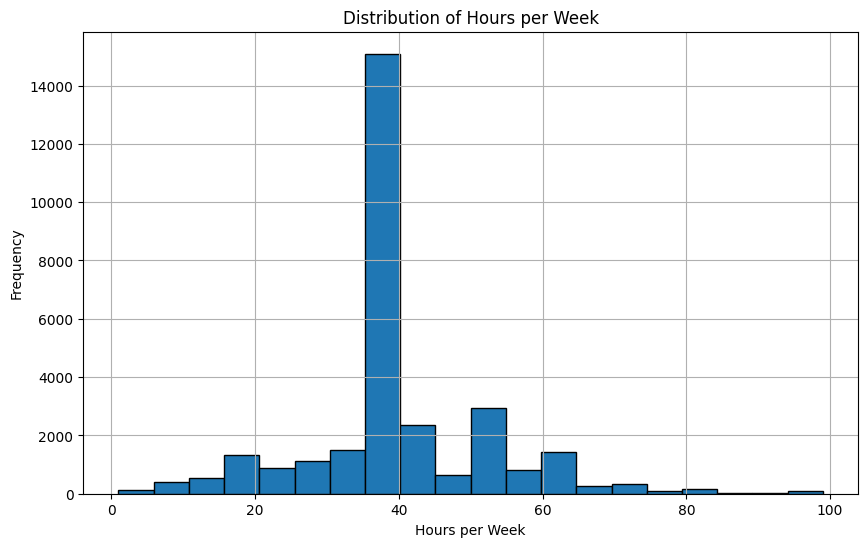

In [7]:
temp=data["hours.per.week"]
print("Max:",temp.max())
print("Min:",temp.min())
plt.figure(figsize=(10, 6))
plt.hist(temp, bins=20, edgecolor='black')
plt.xlabel('Hours per Week')
plt.ylabel('Frequency')
plt.title('Distribution of Hours per Week')
plt.grid(True)
plt.show()

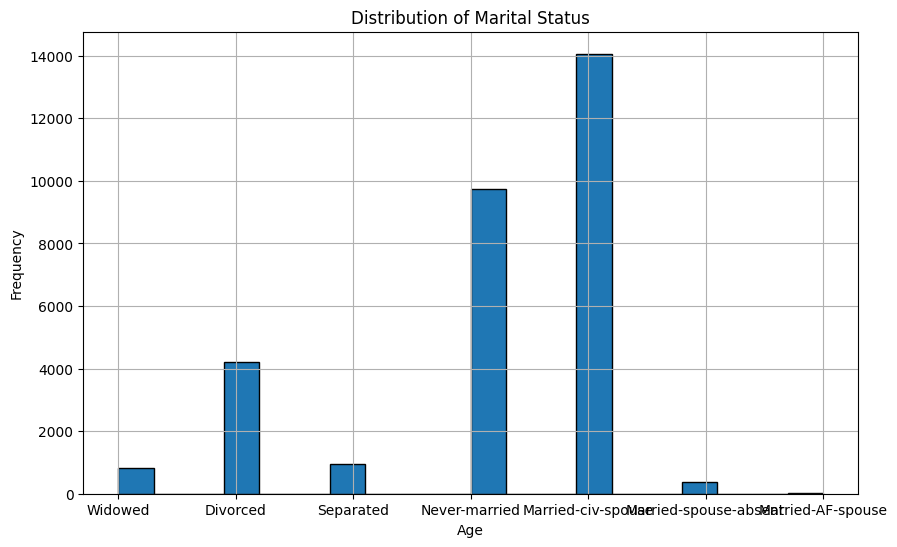

In [8]:
temp=data["marital.status"]
plt.figure(figsize=(10, 6))
plt.hist(temp, bins=20, edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Marital Status')
plt.grid(True)
plt.show()

**Discretization**

Dividing continuous data into bins enables computation by Bayesian networks using built-in libraries after observing graphs.

In [9]:
discretized_data = data.copy()
bin_edges_age = [0, 20, 35, 50, 60, 100]
discretized_data['age'] = pd.cut(data['age'], bins=bin_edges_age, labels=[0,1,2,3,4],right=False).cat.codes
#  custom bin edges and labels for hours.per.week
bin_edges = [0, 20, 35, 40, 60, 80, 100]
bin_labels = ['0-20', '19-35', '36-40', '41-60', '61-80', '81-100']

# Apply pd.cut to categorize ages
discretized_data['hours.per.week'] = pd.cut(data['hours.per.week'], bins=bin_edges, labels=bin_labels, right=False).cat.codes
discretized_data = discretized_data.loc[discretized_data['native.country'] == 'United-States']

# Defining functions for mapping
def map_education_category(edu):
    if edu == 'Preschool':
        return 'No formal education'
    elif edu in ['1st-4th', '5th-6th', '7th-8th', '9th']:
        return 'Primary'
    elif edu in ['10th', '11th', '12th', 'HS-grad']:
        return 'Secondary'
    elif edu in ['Some-college', 'Assoc-voc', 'Assoc-acdm', 'Bachelors', 'Masters', 'Prof-school', 'Doctorate']:
        return 'Tertiary'
    else:
        return 'Unknown'

def map_marry_status(status):
    if status in ['Widowed','Divorced']:
        return 'Single Parent'
    elif status in ['Never-married']:
        return 'Single'
    elif status in ['Separated', 'Married-civ-spouse', 'Married-spouse-absent', 'Married-AF-spouse']:
        return 'Married'
    else:
        return 'Unknown'

def map_occupation_category(occ):
    if occ in ['Exec-managerial', 'Prof-specialty']:
        return 'Professional/Management'
    elif occ in ['Machine-op-inspct', 'Craft-repair', 'Tech-support']:
        return 'Technical/Skilled Trade'
    elif occ in ['Adm-clerical', 'Other-service', 'Priv-house-serv']:
        return 'Administrative/Service'
    elif occ in ['Sales', 'Transport-moving']:
        return 'Sales/Transport'
    elif occ in ['Protective-serv', 'Handlers-cleaners']:
        return 'Protective/Manual Labor'
    elif occ in ['Farming-fishing', 'Armed-Forces']:
        return 'Agricultural/Military'
    else:
        return 'Unknown'

def map_race(race):
    if race == 'White':
        return 'White'
    elif race == 'Black':
        return 'Black'
    else:
        return 'Other'


# Apply the mapping function to create a new column
discretized_data['education'] = discretized_data['education'].apply(map_education_category)
discretized_data['marital.status'] = discretized_data['marital.status'].apply(map_marry_status)
discretized_data['occupation'] = discretized_data['occupation'].apply(map_occupation_category)
discretized_data['race'] = discretized_data['race'].apply(map_race)



# 3. Use this preprocessed data for splitting
discretized_data.drop('native.country', axis=1, inplace=True)
discretized_data.drop('relationship',axis=1,inplace=True)
X = discretized_data.drop('income', axis=1)
y = discretized_data['income']


X_train, X_test, y_train, y_test = train_test_split(
    X, y,train_size=0.5 ,test_size=0.1, random_state=28, shuffle=True)
train_data=pd.concat([X_train,y_train],axis=1)
print(train_data.shape)


(13752, 9)


In [10]:
#checking unique values
print(discretized_data.nunique())
counts = discretized_data['race'].value_counts()



age               5
workclass         7
education         4
marital.status    3
occupation        6
race              3
sex               2
hours.per.week    6
income            2
dtype: int64


**Data Driven**

Applying data driven approach to find the structure of Bayesian network, which is greedy method start from empty network to maximize the score


In [11]:
HC=HillClimbSearch(data=train_data,use_cache="False")
network={}
best_model=HC.estimate(scoring_method="K2score")
print("Score:",best_model.edges())
best_model_edges=best_model.edges()


#now using that structure,





  0%|          | 0/1000000 [00:00<?, ?it/s]

Score: [('age', 'marital.status'), ('age', 'occupation'), ('age', 'workclass'), ('age', 'income'), ('age', 'sex'), ('workclass', 'occupation'), ('education', 'occupation'), ('education', 'income'), ('education', 'age'), ('education', 'hours.per.week'), ('marital.status', 'income'), ('marital.status', 'sex'), ('marital.status', 'occupation'), ('race', 'occupation'), ('sex', 'occupation'), ('sex', 'race'), ('sex', 'workclass'), ('hours.per.week', 'age'), ('hours.per.week', 'occupation'), ('hours.per.week', 'sex'), ('hours.per.week', 'marital.status'), ('income', 'occupation'), ('income', 'race'), ('income', 'workclass')]


Plotting the graph, which also shows some unnecessary or illogical edges, so we will add certain edges to a blacklist—for example, sex, age, and race cannot be influenced by any other node.

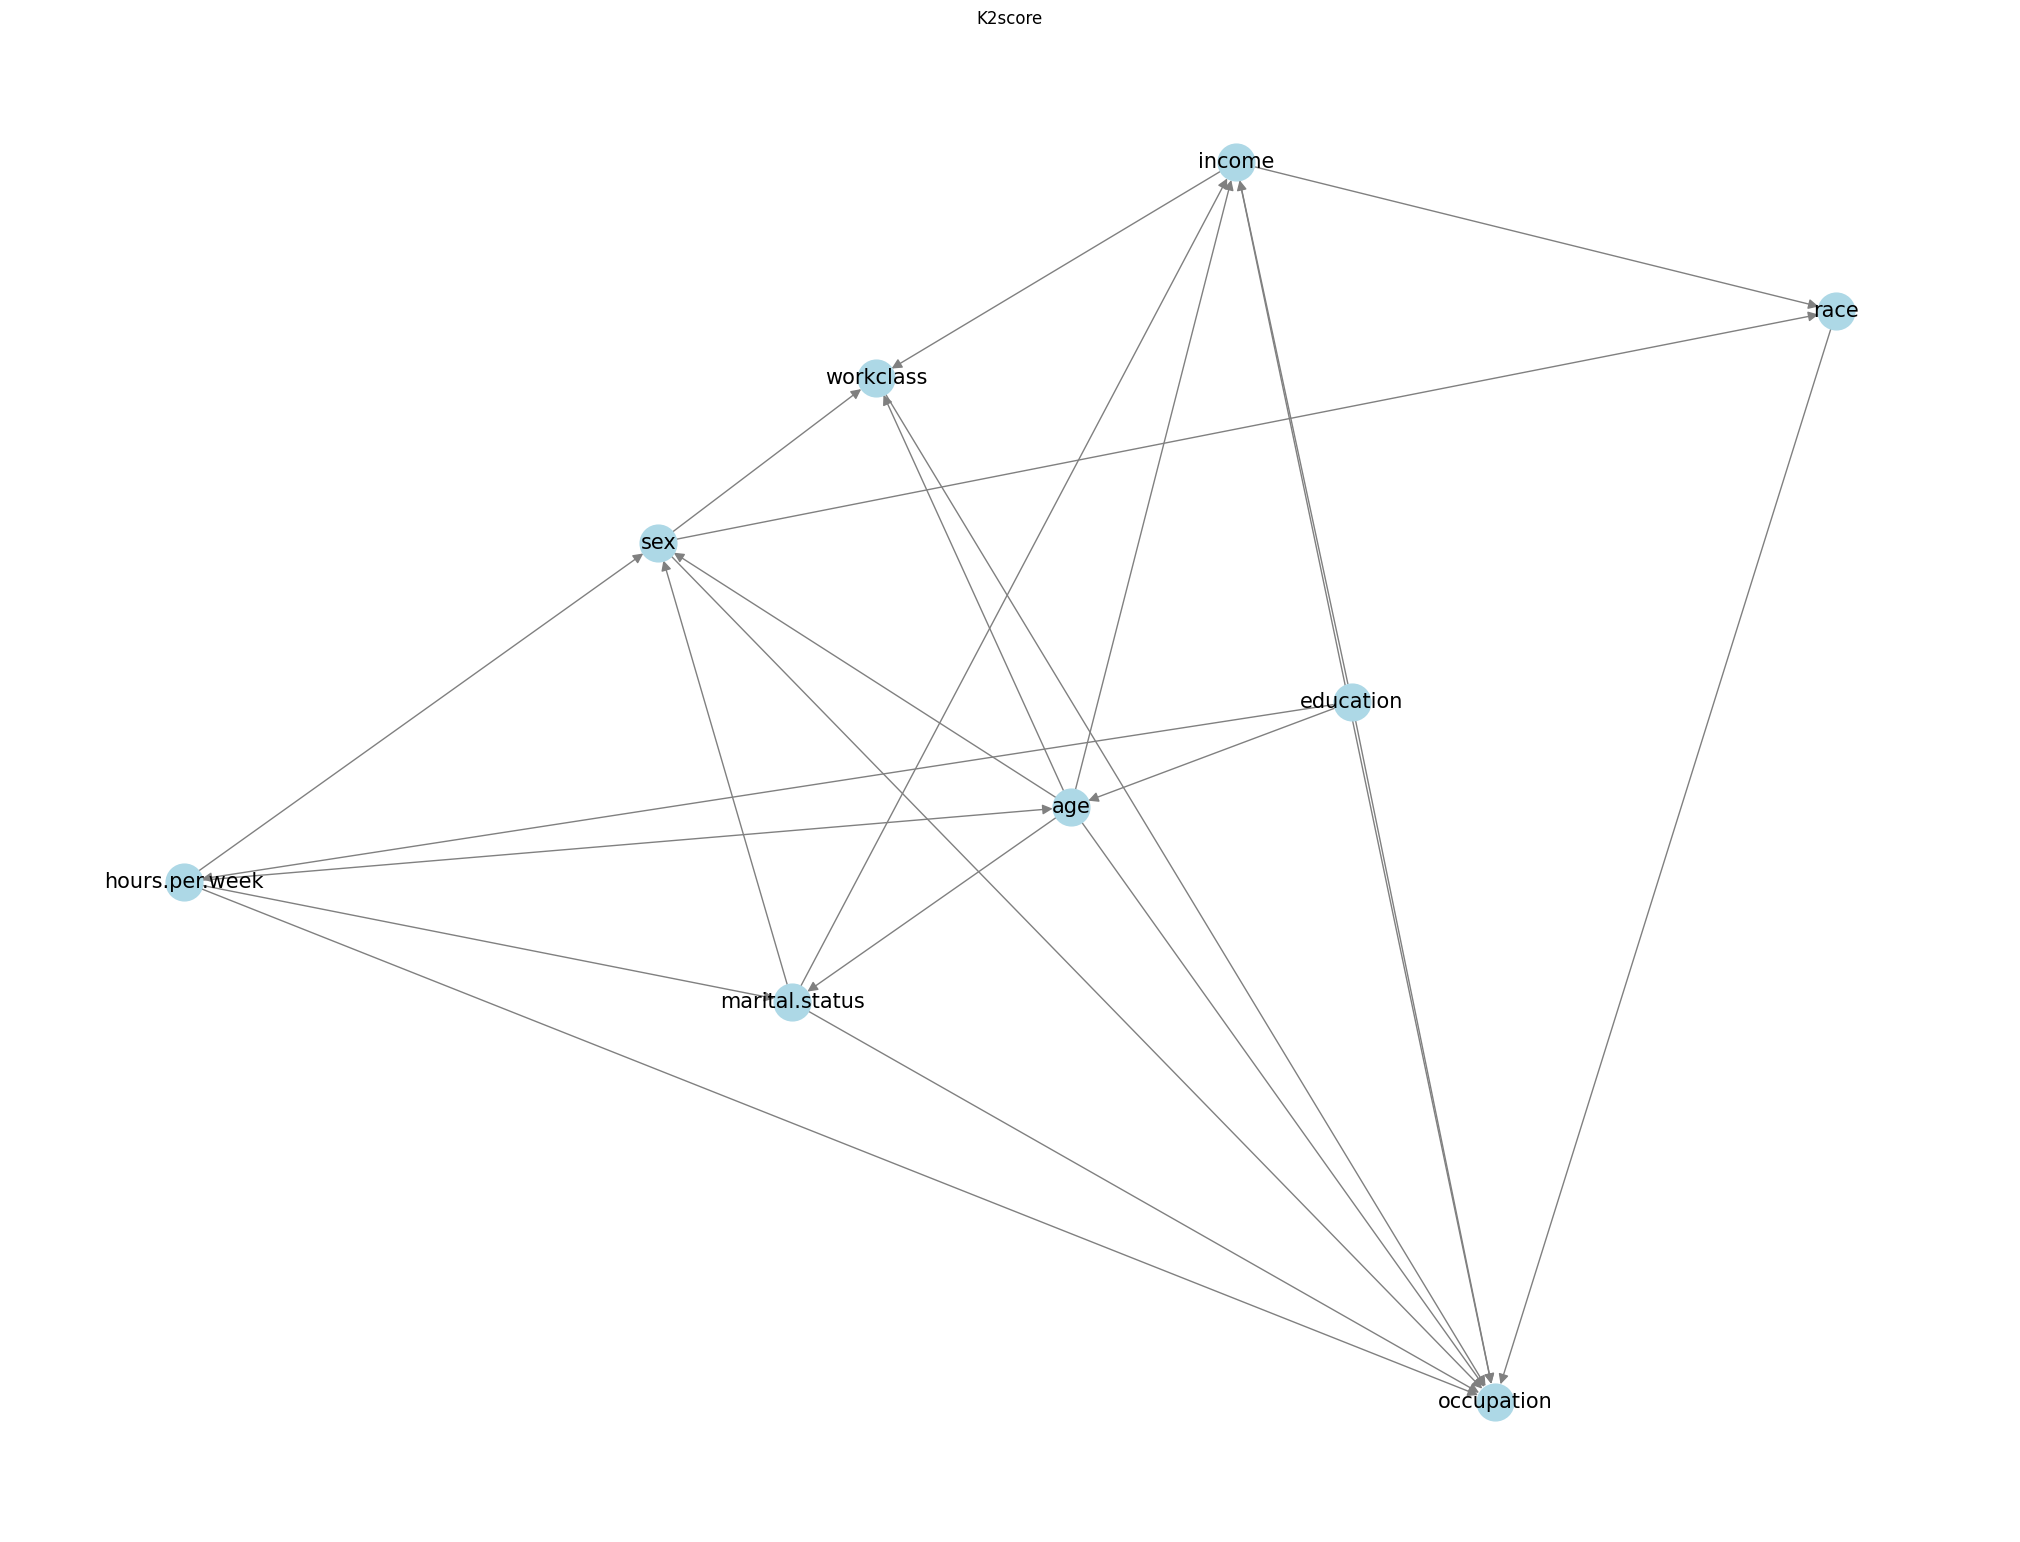

In [12]:
fig = plt.figure(figsize=(20,15))

G = nx.DiGraph()
G.add_edges_from(best_model_edges)
pos = nx.spring_layout(G, k=0.5)

nx.draw(G, pos, with_labels=True,
        node_color='lightblue',
        node_size=700,
        edge_color='gray',
        arrowsize=15,
        font_size=15)

plt.title("K2score")
plt.show()



Adding blacklist and running it again

In [13]:
blacklist=[]
blacklist += [
    # Diabetes diagnosis (class) should be terminal node
    *[('income', col) for col in data.columns if col != 'income'],  # No outgoing edges
]

blacklist += [
    # Diabetes diagnosis (class) should be terminal node
    *[(col, "age") for col in data.columns if col != 'age'],  # No outgoing edges
]
blacklist += [
    # Diabetes diagnosis (class) should be terminal node
    *[(col, "race") for col in data.columns if col != 'race'],  # No outgoing edges
]
blacklist += [
    # Diabetes diagnosis (class) should be terminal node
    *[(col, "sex") for col in data.columns if col != 'sex'],  # No outgoing edges
]



best_model=HC.estimate(scoring_method="K2score",black_list=blacklist,max_indegree=2)
print("score :",best_model.edges())
best_model_edges=best_model.edges()

  0%|          | 0/1000000 [00:00<?, ?it/s]

score : [('age', 'marital.status'), ('age', 'hours.per.week'), ('age', 'education'), ('education', 'occupation'), ('marital.status', 'income'), ('occupation', 'workclass'), ('occupation', 'income'), ('sex', 'marital.status'), ('sex', 'occupation'), ('sex', 'hours.per.week'), ('sex', 'workclass')]


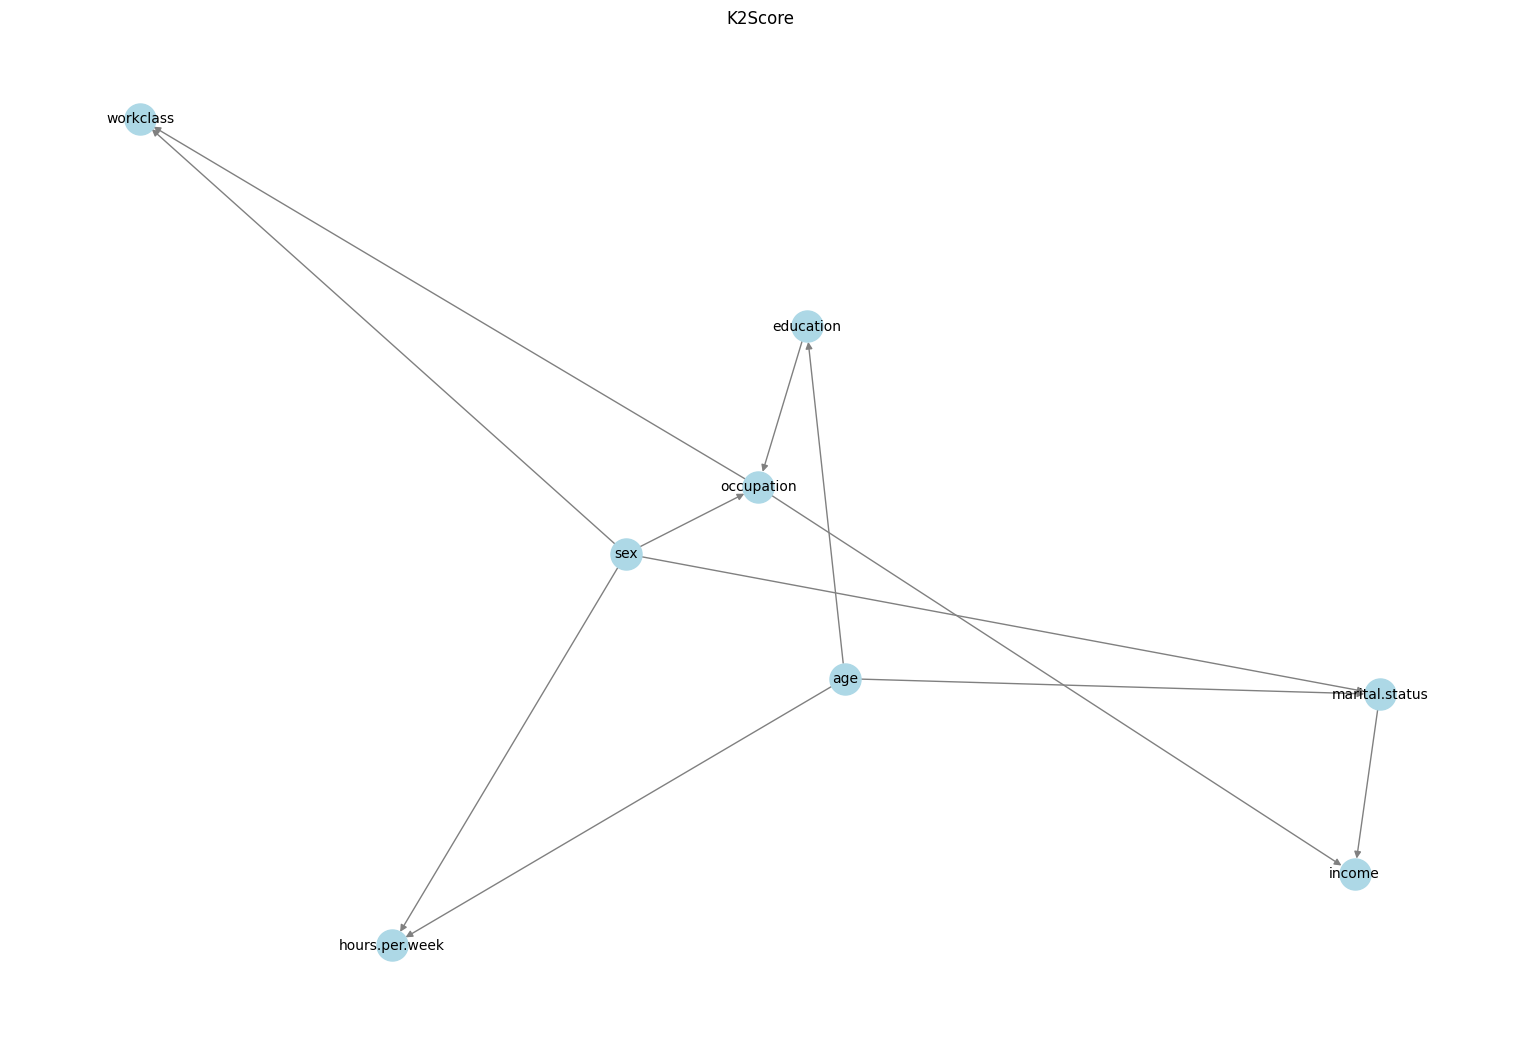

In [14]:
fig = plt.figure(figsize=(15,10))

G = nx.DiGraph()
G.add_edges_from(best_model_edges)
pos = nx.spring_layout(G, k=0.5)

nx.draw(G, pos, with_labels=True,
        node_color='lightblue',
        node_size=500,
        edge_color='gray',
        arrowsize=10,
        font_size=10)

plt.title("K2Score")
plt.show()



It eliminated race from the graph, so we are adding it back as it affects workclass and plotting the final graph


In [15]:

best_model.add_edge('race','workclass')

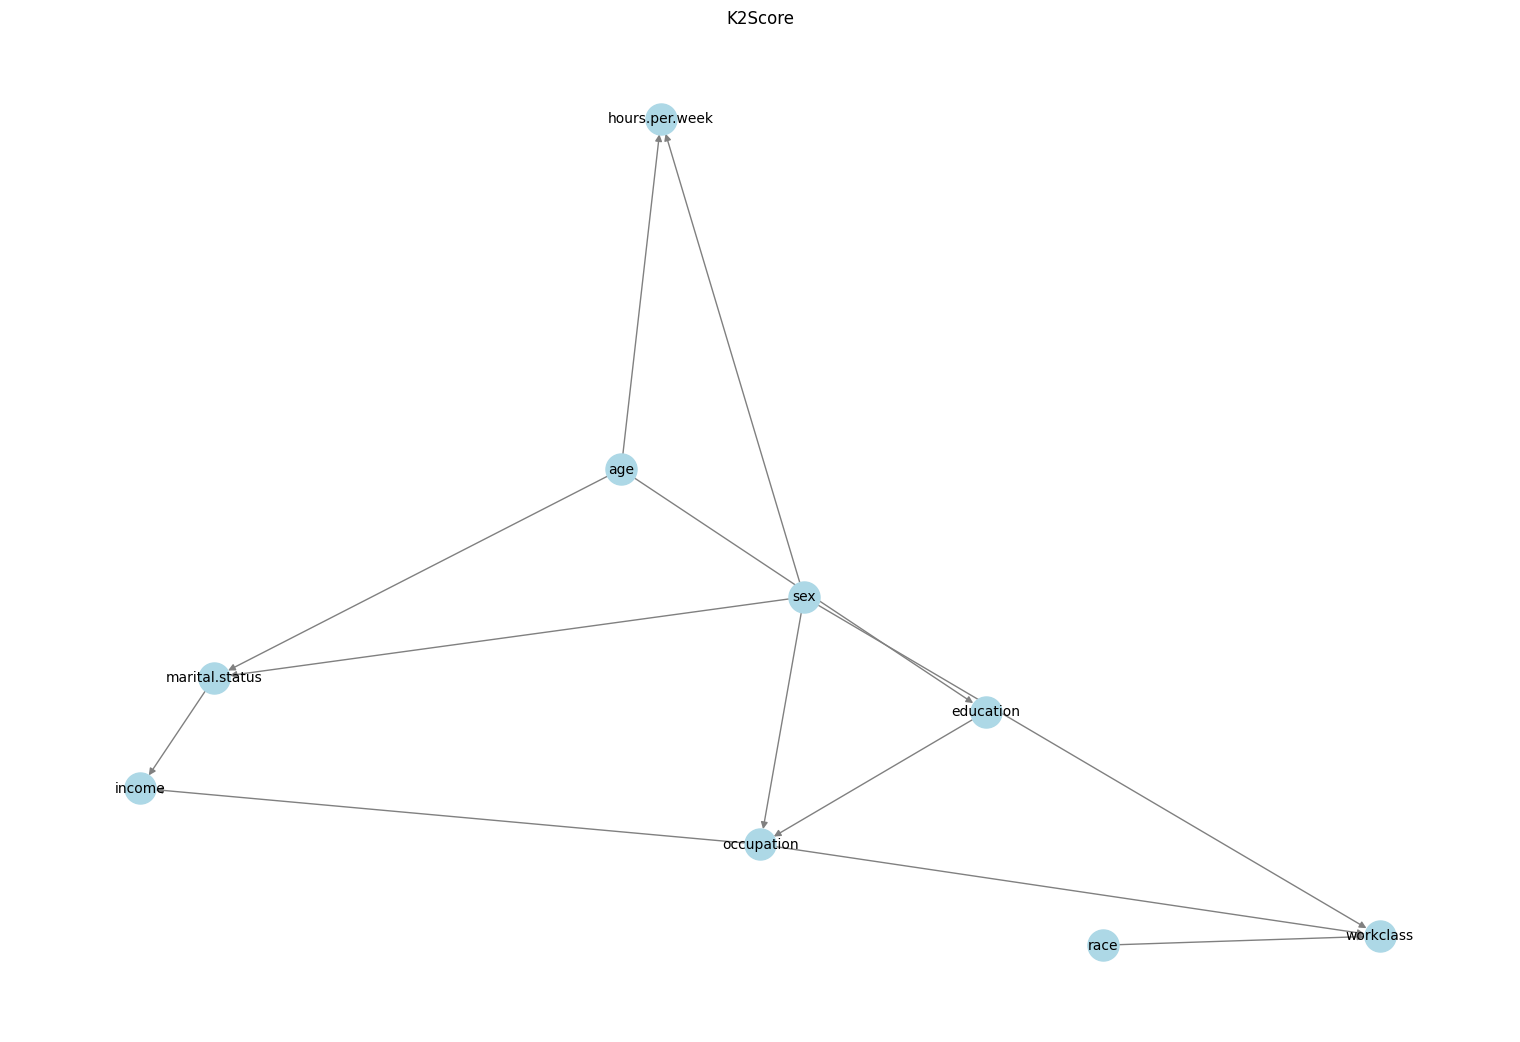

In [16]:
fig = plt.figure(figsize=(15,10))

G = nx.DiGraph()
G.add_edges_from(best_model_edges)
pos = nx.spring_layout(G, k=0.5)

nx.draw(G, pos, with_labels=True,
        node_color='lightblue',
        node_size=500,
        edge_color='gray',
        arrowsize=10,
        font_size=10)

plt.title("K2Score")
plt.show()


**Model Training**

Using Maximum Likelihood Estimator in data driven approach as we didnot have the prior knowledge of domain and then training and predicting the model, showing 80% of accuracy also saving the model in the drive for comparison with Domain Knolwdge Approach


In [17]:
#for score in scores:
best_model_edges=best_model.edges()
model=BayesianNetwork(best_model_edges)
model.fit(train_data, estimator=MaximumLikelihoodEstimator)
y_pred=model.predict(X_test)
print("Accuracy :",accuracy_score(y_test,y_pred))



  0%|          | 0/1150 [00:00<?, ?it/s]

Accuracy : 0.8007997091966558


In [56]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
import pickle

In [47]:
import os

path = "/content/drive/MyDrive/Colab Notebooks"
if not os.path.exists(path):
    print("Directory does not exist! Creating it...")
    os.makedirs(path)
else:
    print("Directory exists!")
# Define the correct path
save_path = "/content/drive/MyDrive/Colab Notebooks/data_driven_bayesian_income.pkl"

# Save using pickle
with open(save_path, 'wb') as file:
    pickle.dump(model, file)


Directory exists!


# **Domain Knowledge**


Predefining edges that can affect other nodes, then training the model and making predictions to evaluate accuracy. Its showing less then the data-driven approach so lets test the model using inference and also see the conditional independencies


In [18]:
edges = [
    ("education", "occupation"),
    ("occupation", "income"),
    ("occupation", "workclass"),
    ("education", "income"),
    ("sex", "hours.per.week"),
    ("hours.per.week", "income"),
    ("race", "workclass"),
    ("workclass", "income"),
    ("marital.status", "hours.per.week"),
    ("age", "workclass"),
    ("marital.status", "occupation"),
    ("age","marital.status")
]


model_22=BayesianNetwork(edges)
print(model_22.nodes())
model_22.fit(train_data, estimator=BayesianEstimator)
y_pred_22=model_22.predict(X_test,n_jobs=1)
print("Domain Based ",accuracy_score(y_test,y_pred_22))

['education', 'occupation', 'income', 'workclass', 'sex', 'hours.per.week', 'race', 'marital.status', 'age']


  0%|          | 0/1150 [00:00<?, ?it/s]

Domain Based  0.7691748455107233


​In a Bayesian Network, the Markov blanket of a node consists of its parents, its children, and the other parents of its children. This set of nodes encapsulates all the variables that shield the node from the rest of the network, meaning that the node is conditionally independent of all other nodes given its Markov blanket, can also see Markov Blanket of any other node

In [19]:
model_22.get_markov_blanket("income")

['workclass', 'occupation', 'education', 'hours.per.week']

**Inference**

How the combination of evidences effect the prediction. As in domain driven approach, Income mainly depends on workclass, Occupation, Education and Hours per week. So will see the effect of these viarable on the model prediction


In All of these variables first will try with the maximum capability of income more then 50k

In [23]:
#Profession
infer = VariableElimination(model_22)
occupation_value="Professional/Management"
query = infer.query(
variables=['income'],
evidence={'occupation': occupation_value,

                  },
    )
print("Domain based Knowledge")
print(f"\nP(income | occupation='{occupation_value}'):")
print(query)

infer = VariableElimination(model)

occupation_value="Professional/Management"
query = infer.query(
variables=['income'],
evidence={'occupation': occupation_value,
                  },
    )
print("Data Driven Approach")
print(f"\nP(income | occupation='{occupation_value}'):")
print(query)

Domain based Knowledge

P(income | occupation='Professional/Management'):
+---------------+---------------+
| income        |   phi(income) |
+===============+===============+
| income(<=50K) |        0.5512 |
+---------------+---------------+
| income(>50K)  |        0.4488 |
+---------------+---------------+
Data Driven Approach

P(income | occupation='Professional/Management'):
+---------------+---------------+
| income        |   phi(income) |
+===============+===============+
| income(<=50K) |        0.5766 |
+---------------+---------------+
| income(>50K)  |        0.4234 |
+---------------+---------------+


In the comparison of Hour per week, Domain Based model works more better then data driven approach, as its showingthe probability of more then 70% income for the people in the range of 80-100 while Domain based showing around 50% which is more logically correct also same in the range of 60-80. Because if someone is working on average 70 hours per week, means he/she is belongs to agricultural or labor department

In [48]:
#Hours per week
infer = VariableElimination(model_22)

#occupation_states = model_22.get_cpds('occupation').state_names['occupation']
Hours_per_week="80-100"
query = infer.query(
variables=['income'],
evidence={
                  "hours.per.week":5
                  },
    )
print("Domain based Knowledge")
print(f"\nP(income | Hours per week='{Hours_per_week}'):")
print(query)

infer = VariableElimination(model)

query = infer.query(
variables=['income'],
evidence={
                  "hours.per.week":5
                  },
    )
print("Data Driven Approach")
print(f"\nP(income | Hours per week='{Hours_per_week}'):")
print(query)

Domain based Knowledge

P(income | Hours per week='80-100'):
+---------------+---------------+
| income        |   phi(income) |
+===============+===============+
| income(<=50K) |        0.5484 |
+---------------+---------------+
| income(>50K)  |        0.4516 |
+---------------+---------------+
Data Driven Approach

P(income | Hours per week='80-100'):
+---------------+---------------+
| income        |   phi(income) |
+===============+===============+
| income(<=50K) |        0.7129 |
+---------------+---------------+
| income(>50K)  |        0.2871 |
+---------------+---------------+


After checking with different combinations, even domain knowldege model with lower accuracy performing well in the Inference.

Best and worst case from both models

In [22]:


# Initialize inference engine
infer = VariableElimination(model_22)

# Step 1: Identify parents of income
parents_of_income = model_22.get_parents("income")

# Step 2: Get states of each parent
state_names = {}
for parent in parents_of_income:
    cpd = model_22.get_cpds(parent)
    state_names[parent] = cpd.state_names[parent]

print(state_names)

# Step 3: Generate all combinations
parent_states = [state_names[parent] for parent in parents_of_income]
all_combinations = itertools.product(*parent_states)

# Step 4: Track maximum and minimum probabilities
max_prob = -1
min_prob = 2  # Initialize to a value higher than 1
best_evidence_max = {}
best_evidence_min = {}

for combination in all_combinations:
    evidence = {parent: value for parent, value in zip(parents_of_income, combination)}
    query = infer.query(variables=['income'], evidence=evidence)

    prob_high_income = query.values[1]

    # Update maximum
    if prob_high_income > max_prob:
        max_prob = prob_high_income
        best_evidence_max = evidence.copy()

    # Update minimum
    if prob_high_income < min_prob:
        min_prob = prob_high_income
        best_evidence_min = evidence.copy()

# Step 5: Print results
print(f"Maximum probability of income >50k: {max_prob:.4f}")
print("Evidence for maximum:")
for var, val in best_evidence_max.items():
    print(f" - {var}: {val}")

print(f"\nMinimum probability of income >50k: {min_prob:.6f}")
print("Evidence for minimum:")
for var, val in best_evidence_min.items():
    print(f" - {var}: {val}")

{'occupation': ['Administrative/Service', 'Agricultural/Military', 'Professional/Management', 'Protective/Manual Labor', 'Sales/Transport', 'Technical/Skilled Trade'], 'education': ['No formal education', 'Primary', 'Secondary', 'Tertiary'], 'hours.per.week': [np.int8(0), np.int8(1), np.int8(2), np.int8(3), np.int8(4), np.int8(5)], 'workclass': ['Federal-gov', 'Local-gov', 'Private', 'Self-emp-inc', 'Self-emp-not-inc', 'State-gov', 'Without-pay']}
Maximum probability of income >50k: 0.9994
Evidence for maximum:
 - occupation: Professional/Management
 - education: Secondary
 - hours.per.week: 4
 - workclass: Self-emp-inc

Minimum probability of income >50k: 0.000035
Evidence for minimum:
 - occupation: Agricultural/Military
 - education: Secondary
 - hours.per.week: 3
 - workclass: Private


In [36]:

#data driven approach
model = BayesianNetwork(best_model.edges())  # Create a BayesianNetwork
model.fit(train_data, estimator=MaximumLikelihoodEstimator) # Fit the model to your data
infer = VariableElimination(model) # Now use this 'model' for inference


# Step 1: Identify parents of income
parents_of_income = best_model.get_parents("income")

# Step 2: Get states of each parent
state_names = {}
for parent in parents_of_income:
    cpd = model.get_cpds(parent)
    state_names[parent] = cpd.state_names[parent]

# Step 3: Generate all combinations
parent_states = [state_names[parent] for parent in parents_of_income]
all_combinations = itertools.product(*parent_states)

# Step 4: Track maximum and minimum probabilities
max_prob = -1
min_prob = 2  # Initialize to a value higher than 1
best_evidence_max = {}
best_evidence_min = {}

for combination in all_combinations:
    evidence = {parent: value for parent, value in zip(parents_of_income, combination)}
    query = infer.query(variables=['income'], evidence=evidence)
    prob_high_income = query.values[1]

    # Update maximum
    if prob_high_income > max_prob:
        max_prob = prob_high_income
        best_evidence_max = evidence.copy()

    # Update minimum
    if prob_high_income < min_prob:
        min_prob = prob_high_income
        best_evidence_min = evidence.copy()

# Step 5: Print results
print(f"Maximum probability of income >50k: {max_prob:.4f}")
print("Evidence for maximum:")
for var, val in best_evidence_max.items():
    print(f" - {var}: {val}")

print(f"\nMinimum probability of income >50k: {min_prob:.6f}")
print("Evidence for minimum:")
for var, val in best_evidence_min.items():
    print(f" - {var}: {val}")

Maximum probability of income >50k: 0.6810
Evidence for maximum:
 - marital.status: Married
 - occupation: Professional/Management
 - race: White

Minimum probability of income >50k: 0.000000
Evidence for minimum:
 - marital.status: Married
 - occupation: Agricultural/Military
 - race: Black


**Findings**

​In our recent analysis, we observed that while the domain knowledge model exhibited lower overall accuracy compared to the data-driven approach, it provided more reliable and interpretable results during inference. This suggests that domain expertise can guide the model to focus on relevant features, leading to more meaningful predictions, even if the overall accuracy metric is lower.​

To enhance model performance, a hybrid approach that integrates both domain knowledge and data-driven methods is recommended. This combination leverages the strengths of both paradigms, potentially improving robustness and interpretability. For instance, embedding domain knowledge into machine learning models can enhance their stability and performance, especially when data is limited or noisy.


In [58]:
import os
import pickle

path = "/content/drive/MyDrive/Colab Notebooks"
if not os.path.exists(path):
    print("Directory does not exist! Creating it...")
    os.makedirs(path)
else:
    print("Directory exists!")
# Define the correct path
save_path = "/content/drive/MyDrive/Colab Notebooks/domain_bayesian_income.pkl"

# Save using pickle
with open(save_path, 'wb') as file:
    pickle.dump(model, file)


Directory exists!
